In [1]:
# Импортируем необходимые библиотека
import numpy as np
import pandas as pd

import seaborn
import matplotlib
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt

import re
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Импорт данных

In [2]:
df = pd.read_csv("tea_demand.csv", sep='\s+')
df

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185
...,...,...,...
454,178,2016-11-29,222
455,29,2016-11-29,1173
456,5152,2016-11-30,311
457,178,2016-11-30,227


In [3]:
# Выделим отдельный датасет с чаем ahmad
df_ahmad = df.loc[df['brand_id']==178].reset_index(drop=True)
df_ahmad

,brand_id,date,receipts_count
0,178,2016-07-01,234
1,178,2016-07-02,185
2,178,2016-07-03,190
3,178,2016-07-04,196
4,178,2016-07-05,336
...,...,...,...
148,178,2016-11-26,238
149,178,2016-11-27,229
150,178,2016-11-28,267
151,178,2016-11-29,222


In [4]:
# Посмотрим информацию по датасету ahmad
df_ahmad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand_id        153 non-null    int64 
 1   date            153 non-null    object
 2   receipts_count  153 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ KB


In [5]:
# Посмотрим информацию по данным датасета ahmad
df_ahmad.describe()

,brand_id,receipts_count
count,153.0,153.000000
mean,178.0,327.045752
std,0.0,134.810703
min,178.0,143.000000
25%,178.0,227.000000
50%,178.0,275.000000
75%,178.0,399.000000
max,178.0,712.000000


# 2. Парсинг информации проведения игр 'Что? Где? Когда?'

In [6]:
def parser(url: str):
    """
    Парсер с сайта https://www.toramp.com. Парсинг информации с наименованием и датой проведения игр 'Что? Где? Когда?', 
    за все возможные года 
    """
    # Запрос по ссылке
    response = requests.get(url).text

    # Парсим страницу полученную с запроса
    soup = BeautifulSoup(response, "html.parser")

    # Выбираем все даты игр
    all_dates = soup.find_all('time', class_='nowrap')

    # Выбираем все названия игр
    all_titles = soup.findAll('div', class_='ft')

    # Проверим длину списков с датами и названиями игр
    try:
        if len(all_dates) != len(all_titles):
            raise ValueError()
    except ValueError as e:
        return str('Не удалось корректно распарсить страницу, длина списков не совпадает, \
                   длина списка с датами = {}, длина списка с названиями игр = {}' \
                   .format(len(all_dates), len(all_titles)))

    # Создадим список и заполним его словарями по каждой игре ключ - date, значение - title
    games_lst = []
    for date, title in zip(all_dates, all_titles):
        game_dict = dict()
        game_date = re.findall(r'\d{4}-\d{2}-\d{2}', str(date))[0]
        game_title = title.text
        # Вставим значения в сдловарь
        try:
            if game_date and game_title:
                game_dict['date'] = game_date
                game_dict['title'] = game_title
            else:
                game_date = np.nan
                game_title = np.nan
                raise ValueError()
        except:
            print('Одно из значений обрабатываемой строки пустое. \n \
            game_date = {}, \ngame_title = {}'.format(game_date, game_title))
            pass
        games_lst.append(game_dict)

    return games_lst

In [7]:
# Зададим ссылку сайта для парсинга
url = 'https://www.toramp.com/schedule.php?id=3857'

In [8]:
# Парсим данные: дата проведение игр и их наименование
data_games = parser(url)

In [9]:
# Создадим датасет из данных парсинга
df_games = pd.DataFrame(data_games)
# Сохраним датасет
df_games.to_csv('data_games.csv')
df_games

,date,title
0,2021-03-21,Весенняя серия. Игра первая. Овдеенко.
1,2021-03-28,Весенняя серия. Игра вторая. Белозёров.
2,2021-04-04,Весенняя серия. Игра третья. Козлов.
3,2021-04-11,Весенняя серия. Игра четвёртая. Касумов.
4,2021-04-18,Весенняя серия игр. Финал. Касумов
...,...,...
554,1976-04-24,Игра со студентами МГУ
555,1975-09-04,Семейная викторина „Что? Где? Когда?“
556,2002-03-16,Владимир Ворошилов: «Игра — это репетиция жизн...
557,2015-11-29,«До первого крика совы» - док. фильм к 40-лети...


# 3. Объединение датасетов ahmad и игр Что? Где? Когда?

In [10]:
# Приведем к одному типу даты датасетов
df_ahmad['date'] = pd.to_datetime(df_ahmad['date'])
df_games['date'] = pd.to_datetime(df_games['date'])

In [11]:
# Объединим датасеты
df_concat = df_ahmad.merge(df_games, how='left', on='date')
df_concat

,brand_id,date,receipts_count,title
0,178,2016-07-01,234,NaN
1,178,2016-07-02,185,NaN
2,178,2016-07-03,190,NaN
3,178,2016-07-04,196,NaN
4,178,2016-07-05,336,NaN
...,...,...,...,...
148,178,2016-11-26,238,NaN
149,178,2016-11-27,229,NaN
150,178,2016-11-28,267,Зимняя серия. Игра вторая. Сиднев.
151,178,2016-11-29,222,NaN


In [12]:
# Посмотрим на пересекающиеся данные
df_concat.loc[df_concat['title'].notna()]

,brand_id,date,receipts_count,title
86,178,2016-09-25,223,Осенняя серия. Игра первая. Козлов.
93,178,2016-10-02,239,Осенняя серия. Игра вторая. Рудер.
100,178,2016-10-09,401,Осенняя серия. Игра третья. Повышева.
107,178,2016-10-16,262,Осенняя серия. Игра четвёртая. Аскеров.
114,178,2016-10-23,238,Осенняя серия. Финал. Сиднев.
143,178,2016-11-21,241,Зимняя серия. Игра первая. Александрова (Хруст...
150,178,2016-11-28,267,Зимняя серия. Игра вторая. Сиднев.


In [13]:
# Создадим признак, где 1-игра в данный день проводилась, 2 - два дня после игры, 0-нет
df_concat['is_game_day'] = df_concat['title'].apply(lambda x: 2 if type(x)==str else x)
df_concat['is_game_day'] = df_concat['is_game_day'].ffill(limit=2).fillna(0)
df_concat.loc[df_concat['title'].notna(), 'is_game_day'] = 1
df_concat = df_concat.drop('title', axis=1)
df_concat

,brand_id,date,receipts_count,is_game_day
0,178,2016-07-01,234,0.0
1,178,2016-07-02,185,0.0
2,178,2016-07-03,190,0.0
3,178,2016-07-04,196,0.0
4,178,2016-07-05,336,0.0
...,...,...,...,...
148,178,2016-11-26,238,0.0
149,178,2016-11-27,229,0.0
150,178,2016-11-28,267,1.0
151,178,2016-11-29,222,2.0


In [14]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 152
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        153 non-null    int64         
 1   date            153 non-null    datetime64[ns]
 2   receipts_count  153 non-null    int64         
 3   is_game_day     153 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 6.0 KB


In [15]:
# Создадим датасет для отображения графика
df_concat_plot = df_concat.copy()
df_concat_plot = df_concat_plot.set_index(pd.DatetimeIndex(df_concat_plot['date'])).drop('date', axis=1)
df_concat_plot.loc[df_concat_plot['is_game_day']==1, 'receipts_count_gd'] = df_concat_plot['receipts_count']
df_concat_plot

,brand_id,receipts_count,is_game_day,receipts_count_gd
date,,,,
2016-07-01,178,234,0.0,NaN
2016-07-02,178,185,0.0,NaN
2016-07-03,178,190,0.0,NaN
2016-07-04,178,196,0.0,NaN
2016-07-05,178,336,0.0,NaN
...,...,...,...,...
2016-11-26,178,238,0.0,NaN
2016-11-27,178,229,0.0,NaN
2016-11-28,178,267,1.0,267.0


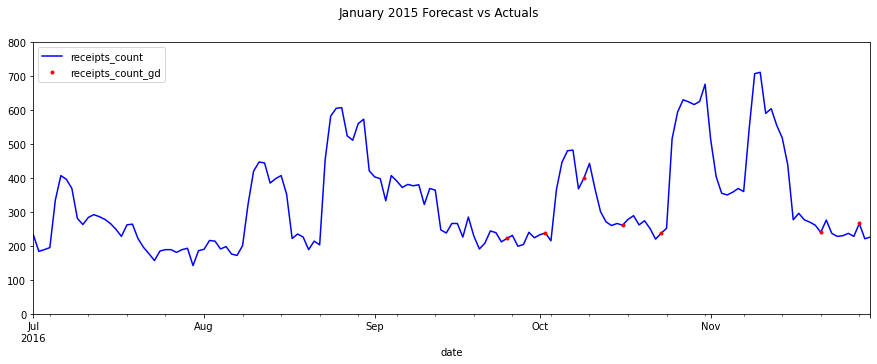

In [16]:
# Посмотрим временной ряд, и отобразим точки с игрой в этот день
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_concat_plot[['receipts_count','receipts_count_gd']].plot(ax=ax,
                                              style=['-','.'], color=['blue', 'red'])
ax.set_ylim(0, 800)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

# 4. Статистический метод определения аномалий

Количество выбросов: 3


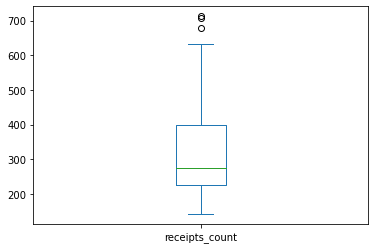

In [17]:
# Построим BoxPlot по признакам из X1 и посмотрим, есть ли выбросы
_, bp = df_concat.receipts_count.plot.box(return_type='both')
outliers = [flier.get_ydata() for flier in bp["fliers"]][0]
print('Количество выбросов: {}'.format(df_concat[df_concat.receipts_count.isin(outliers)].count()[0]))

In [18]:
# Посчитаем выбросы по формуле
Q1 = np.percentile(df_concat['receipts_count'], 25)
Q3 = np.percentile(df_concat['receipts_count'], 75)
IQR = Q3 - Q1
Low_bound = Q1 - 1.5*IQR
High_bound = Q3 + 1.5*IQR
print('Low bound: {},\nHigh bound: {}'.format(Low_bound,  High_bound))
print('Features < Low bound: {}, \nFeatures > High bound: {}'.format(len([x for x in df_concat['receipts_count'] 
                                                                          if x < Low_bound]),
                                                                    len([x for x in df_concat['receipts_count'] 
                                                                         if x > High_bound])))
print('All outliers: {}'.format(len([x for x in df_concat['receipts_count'] if x <= Low_bound])+
                                len([x for x in df_concat['receipts_count'] if x >= High_bound])))

Low bound: -31.0,
High bound: 657.0
Features < Low bound: 0, 
Features > High bound: 3
All outliers: 3


Вывод: статистический метод показал 3 выброса выше верхней границы.

In [19]:
# Проверим сколько продаж после попало в выбросы:
df_concat.loc[((df_concat['receipts_count'] < Low_bound) | 
               (df_concat['receipts_count'] > High_bound))]

,brand_id,date,receipts_count,is_game_day
122,178,2016-10-31,677,0.0
131,178,2016-11-09,708,0.0
132,178,2016-11-10,712,0.0


#### Вывод: Все аномалии по продажам чая "Ахмад" были ни в день игры, ни два дня после.

# 5. Метод определения аномалий с помощью ML

In [20]:
# Несколько вспомогательных методов

def getDistanceByPoint(data, model):
    # Расчет расстояний от точек до центров кластеров
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    distance = pd.Series(distance)    
    return distance

def getTransitionMatrix (df):
    # Расчет вероятностей перехода к следующему состоянию (глупая предсказывалка)
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    # Поиск аномалий в последовательности сигналов исходя из марковской матрицы переходов
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

<AxesSubplot:xlabel='date'>

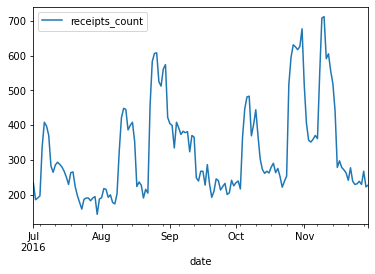

In [21]:
# Посмотрим на временной ряд
df_concat['date'] = pd.to_datetime(df_concat['date'])
df_concat.plot(x='date', y='receipts_count')

In [22]:
# Добавим новые признаки
df_concat['DayOfTheWeek'] = df_concat['date'].dt.dayofweek
df_concat['WeekDay'] = (df_concat['DayOfTheWeek'] < 5).astype(int)
df_concat['time_epoch'] = (df_concat['date'].astype(np.int64)/100000000000).astype(np.int64)
outliers_fraction = 0.01
df_concat

,brand_id,date,receipts_count,is_game_day,DayOfTheWeek,WeekDay,time_epoch
0,178,2016-07-01,234,0.0,4,1,14673312
1,178,2016-07-02,185,0.0,5,0,14674176
2,178,2016-07-03,190,0.0,6,0,14675040
3,178,2016-07-04,196,0.0,0,1,14675904
4,178,2016-07-05,336,0.0,1,1,14676768
...,...,...,...,...,...,...,...
148,178,2016-11-26,238,0.0,5,0,14801184
149,178,2016-11-27,229,0.0,6,0,14802048
150,178,2016-11-28,267,1.0,0,1,14802912
151,178,2016-11-29,222,2.0,1,1,14803776


## 5.1. Clustering models

In [23]:
data = df_concat[['receipts_count', 'is_game_day', 'DayOfTheWeek', 'WeekDay', 'time_epoch']]

# Нормализуем наши данные
starrd_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = starrd_scaler.transform(data)
data = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)

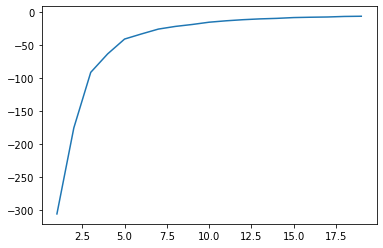

In [24]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j).fit(data) for j in n_cluster]
scores = [km.score(data) for km in kmeans]
#TODO давайте подберем оптимальное число кластеров k-means
#TODO обучить KMeans для заданных числе кластеров
#TODO как подобрать число кластеров?
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [25]:
df_concat['cluster'] = kmeans[3].predict(data)
df_concat['principal_feature1'] = data[0]
df_concat['principal_feature2'] = data[1]
df_concat['cluster'].value_counts()

3    61
2    48
1    25
0    19
Name: cluster, dtype: int64

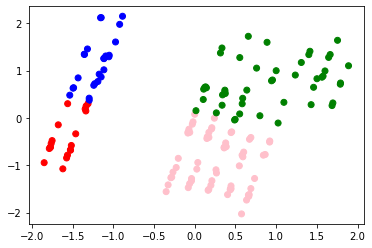

In [26]:
fig, ax = plt.subplots()
colors = {0: 'red', 1: 'blue',
          2: 'green', 3: 'pink',
          4: 'black', 5: 'orange',
          6: 'cyan', 7: 'yellow',
          8: 'brown', 9: 'purple',
          10: 'white', 11: 'grey', 
          12: 'lightblue', 13: 'lightgreen', 
          14: 'darkgrey'}
ax.scatter(df_concat['principal_feature1'], df_concat['principal_feature2'],
           c=df_concat["cluster"].apply(lambda x: colors[x]))
plt.show()

Количество выбросов: 1


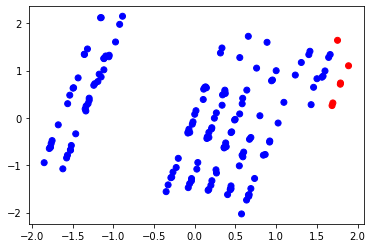

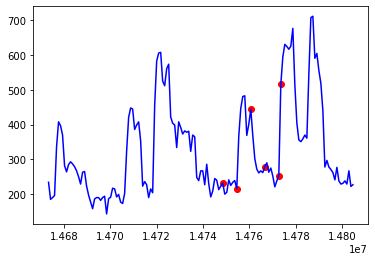

In [27]:
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
print('Количество выбросов: {}'.format(number_of_outliers))
# Считаем точку аномалией, если расстояние до центра кластера больше порога
df_concat['anomaly21'] = (distance >= 3.0).astype(int)

fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df_concat['principal_feature1'], df_concat['principal_feature2'], 
           c=df_concat["anomaly21"].apply(lambda x: colors[x]))
plt.show()

fig, ax = plt.subplots()

a = df_concat.loc[df_concat['anomaly21'] == 1, ['time_epoch', 'receipts_count']] #anomaly

ax.plot(df_concat['time_epoch'], df_concat['receipts_count'], color='blue')
ax.scatter(a['time_epoch'],a['receipts_count'], color='red')
plt.show()

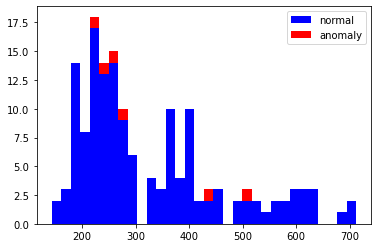

In [28]:
# Посмотрим на распределение аномальных и действительных значений
a = df_concat.loc[df_concat['anomaly21'] == 0, 'receipts_count']
b = df_concat.loc[df_concat['anomaly21'] == 1, 'receipts_count']
fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [29]:
# Посмотрим на аномалии в день игры и два дня после
df_concat.loc[(df_concat['anomaly21'] == 1) & (df_concat['is_game_day'] > 0)]

,brand_id,date,receipts_count,is_game_day,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
87,178,2016-09-26,232,2.0,0,1,14748480,2,1.687013,0.261188,1
94,178,2016-10-03,216,2.0,0,1,14754528,2,1.697133,0.316871,1
101,178,2016-10-10,444,2.0,0,1,14760576,2,1.889618,1.102137,1
108,178,2016-10-17,279,2.0,0,1,14766624,2,1.788375,0.712297,1
115,178,2016-10-24,253,2.0,0,1,14772672,2,1.791020,0.738079,1
116,178,2016-10-25,516,2.0,1,1,14773536,2,1.754353,1.639502,1


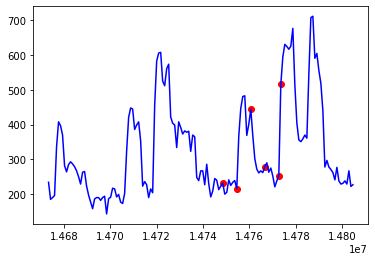

<Figure size 720x720 with 0 Axes>

In [30]:
# Посмотрим на аномалии в день игры и два дня после на графике
fig, ax = plt.subplots()
plt.figure(figsize=(10, 10))

a = df_concat.loc[(df_concat['anomaly21'] == 1) & (df_concat['is_game_day'] == 1), ['time_epoch', 'receipts_count']] 
b = df_concat.loc[(df_concat['anomaly21'] == 1) & (df_concat['is_game_day'] == 2), ['time_epoch', 'receipts_count']] 

ax.plot(df_concat['time_epoch'], df_concat['receipts_count'], color='blue')
ax.scatter(a['time_epoch'],a['receipts_count'], color='magenta')
ax.scatter(b['time_epoch'],b['receipts_count'], color='red')

plt.show()

#### По графику и таблице можно сделать вывод, что в 4 случаях из 5 игра влияла на рост продаж чая "Ахмат".

## 5.2. IsolationForest

In [31]:
# Take useful feature and standardize them 
data = df_concat[['receipts_count', 'is_game_day', 'DayOfTheWeek', 'WeekDay', 'time_epoch']]
# train isolation forest 
model =  IsolationForest(contamination=0.1, random_state=42).fit(data)
# add the data to the main  
df_concat['anomaly25'] = pd.Series(model.predict(data))
df_concat['anomaly25'] = df_concat['anomaly25'].map( {1: 0, -1: 1} )
print(df_concat['anomaly25'].value_counts())

0    137
1     16
Name: anomaly25, dtype: int64


In [32]:
df_concat['receipts_count_diff'] = df_concat['receipts_count'].diff(1)
df_concat.dropna(inplace=True)

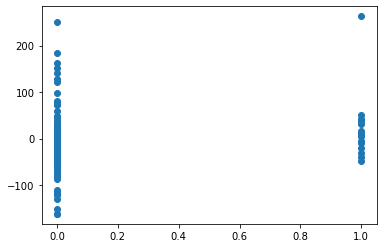

In [33]:
plt.scatter(df_concat['anomaly25'], df_concat['receipts_count_diff'])

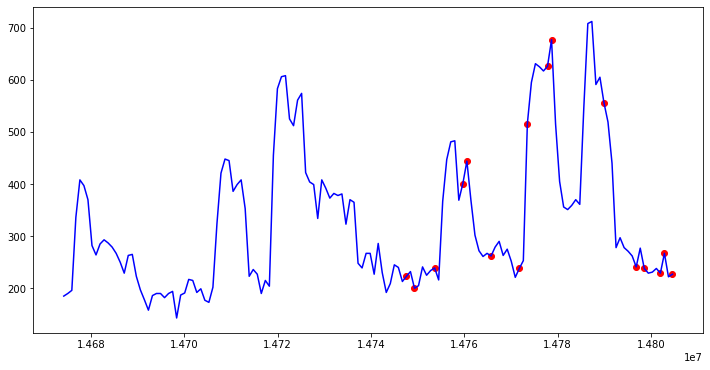

In [34]:
# visualisation of anomaly throughout time (viz 1)
plt.figure(figsize=(12, 6))

a = df_concat.loc[df_concat['anomaly25'] == 1, ['time_epoch', 'receipts_count']] #anomaly

plt.plot(df_concat['time_epoch'], df_concat['receipts_count'], color='blue')
plt.scatter(a['time_epoch'],a['receipts_count'], color='red')
plt.show()

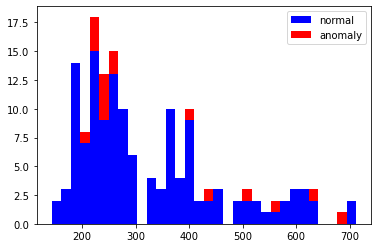

In [35]:
a = df_concat.loc[df_concat['anomaly25'] == 0, 'receipts_count']
b = df_concat.loc[df_concat['anomaly25'] == 1, 'receipts_count']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

In [36]:
# Посмотрим на аномалии в день игры и два дня после
df_concat.loc[(df_concat['anomaly25'] == 1) & (df_concat['is_game_day'] > 0)]

,brand_id,date,receipts_count,is_game_day,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21,anomaly25,receipts_count_diff
86,178,2016-09-25,223,1.0,6,0,14747616,1,-1.151021,0.865127,0,1,10.0
88,178,2016-09-27,200,2.0,1,1,14749344,2,1.429862,0.280534,0,1,-32.0
93,178,2016-10-02,239,1.0,6,0,14753664,1,-1.116984,1.016494,0,1,5.0
100,178,2016-10-09,401,1.0,6,0,14759712,1,-0.973827,1.604413,0,1,32.0
101,178,2016-10-10,444,2.0,0,1,14760576,2,1.889618,1.102137,1,1,43.0
107,178,2016-10-16,262,1.0,6,0,14765760,1,-1.055638,1.292316,0,1,-5.0
114,178,2016-10-23,238,1.0,6,0,14771808,1,-1.051498,1.324078,0,1,17.0
116,178,2016-10-25,516,2.0,1,1,14773536,2,1.754353,1.639502,1,1,263.0
143,178,2016-11-21,241,1.0,0,1,14796864,2,1.460059,0.647098,0,1,-21.0
145,178,2016-11-23,238,2.0,2,1,14798592,2,1.401653,1.337386,0,1,-39.0


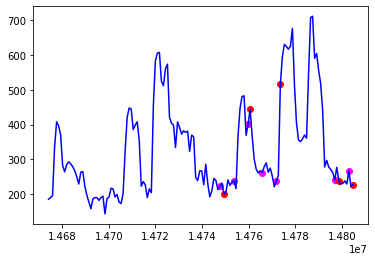

<Figure size 720x720 with 0 Axes>

In [37]:
# Посмотрим на аномалии в день игры и два дня после на графике
fig, ax = plt.subplots()
plt.figure(figsize=(10, 10))

a = df_concat.loc[(df_concat['anomaly25'] == 1) & (df_concat['is_game_day'] == 1), ['time_epoch', 'receipts_count']] 
b = df_concat.loc[(df_concat['anomaly25'] == 1) & (df_concat['is_game_day'] == 2), ['time_epoch', 'receipts_count']] 

ax.plot(df_concat['time_epoch'], df_concat['receipts_count'], color='blue')
ax.scatter(a['time_epoch'],a['receipts_count'], color='magenta')
ax.scatter(b['time_epoch'],b['receipts_count'], color='red')

plt.show()

#### По графику и таблице можно сделать вывод, что в 2 случаях из 5 игра влияла на рост продаж чая "Ахмат".

## 5.3. OneClassSvm

In [38]:
# Применим OneClassSvm
data = df_concat[['receipts_count', 'is_game_day', 'DayOfTheWeek', 'WeekDay', 'time_epoch']]
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
 
model = OneClassSVM()
data = pd.DataFrame(np_scaled)
model.fit(data)  
df_concat['anomaly26'] = pd.Series(model.predict(data))
df_concat['anomaly26'] = df_concat['anomaly26'].map( {1: 0, -1: 1} )
print(df_concat['anomaly26'].value_counts())

0.0    76
1.0    75
Name: anomaly26, dtype: int64


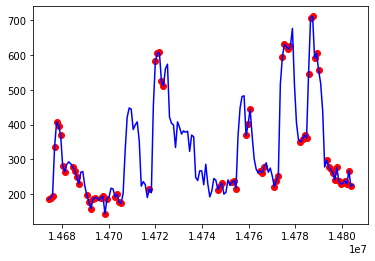

In [39]:
#visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df_concat.loc[df_concat['anomaly26'] == 1, ['time_epoch', 'receipts_count']] #anomaly

ax.plot(df_concat['time_epoch'], df_concat['receipts_count'], color='blue')
ax.scatter(a['time_epoch'],a['receipts_count'], color='red')
plt.show()

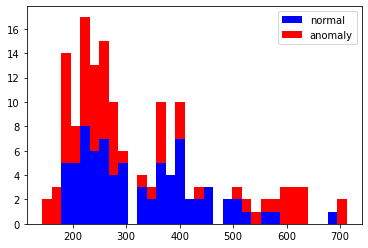

In [40]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df_concat.loc[df_concat['anomaly26'] == 0, 'receipts_count']
b = df_concat.loc[df_concat['anomaly26'] == 1, 'receipts_count']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [41]:
# Посмотрим на аномалии в день игры и два дня после
df_concat.loc[(df_concat['anomaly26'] == 1) & (df_concat['is_game_day'] > 0)]

,brand_id,date,receipts_count,is_game_day,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21,anomaly25,receipts_count_diff,anomaly26
86,178,2016-09-25,223,1.0,6,0,14747616,1,-1.151021,0.865127,0,1,10.0,1.0
87,178,2016-09-26,232,2.0,0,1,14748480,2,1.687013,0.261188,1,0,9.0,1.0
93,178,2016-10-02,239,1.0,6,0,14753664,1,-1.116984,1.016494,0,1,5.0,1.0
94,178,2016-10-03,216,2.0,0,1,14754528,2,1.697133,0.316871,1,0,-23.0,1.0
100,178,2016-10-09,401,1.0,6,0,14759712,1,-0.973827,1.604413,0,1,32.0,1.0
101,178,2016-10-10,444,2.0,0,1,14760576,2,1.889618,1.102137,1,1,43.0,1.0
107,178,2016-10-16,262,1.0,6,0,14765760,1,-1.055638,1.292316,0,1,-5.0,1.0
108,178,2016-10-17,279,2.0,0,1,14766624,2,1.788375,0.712297,1,0,17.0,1.0
114,178,2016-10-23,238,1.0,6,0,14771808,1,-1.051498,1.324078,0,1,17.0,1.0
115,178,2016-10-24,253,2.0,0,1,14772672,2,1.791020,0.738079,1,0,15.0,1.0


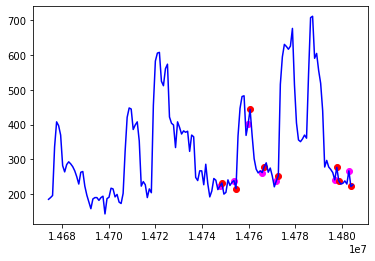

<Figure size 720x720 with 0 Axes>

In [42]:
# Посмотрим на аномалии в день игры и два дня после на графике
fig, ax = plt.subplots()

a = df_concat.loc[(df_concat['anomaly26'] == 1) & (df_concat['is_game_day'] == 1), ['time_epoch', 'receipts_count']] 
b = df_concat.loc[(df_concat['anomaly26'] == 1) & (df_concat['is_game_day'] == 2), ['time_epoch', 'receipts_count']] 

ax.plot(df_concat['time_epoch'], df_concat['receipts_count'], color='blue')
ax.scatter(a['time_epoch'],a['receipts_count'], color='magenta')
ax.scatter(b['time_epoch'],b['receipts_count'], color='red')
plt.figure(figsize=(10, 10))
plt.show()

#### По графику и таблице можно сделать вывод, что в 5 случаях из 7 игра влияла на рост продаж чая "Ахмат".

# 6. Метод определения аномалий с помощью кластеризации

## 6.1. Поищем аномалии, с помощью DBSCAN

In [43]:
dbscan = DBSCAN(min_samples=8, eps=5)

In [44]:
df_concat['prediction_dbscan_1'] = dbscan.fit_predict(df_concat['receipts_count'].values.reshape(-1, 1))
df_concat.head()

,brand_id,date,receipts_count,is_game_day,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21,anomaly25,receipts_count_diff,anomaly26,prediction_dbscan_1
1,178,2016-07-02,185,0.0,5,0,14674176,0,-1.621428,-1.075023,0,0,-49.0,1.0,0
2,178,2016-07-03,190,0.0,6,0,14675040,0,-1.850925,-0.945043,0,0,5.0,1.0,0
3,178,2016-07-04,196,0.0,0,1,14675904,3,0.574562,-2.027152,0,0,6.0,1.0,0
4,178,2016-07-05,336,0.0,1,1,14676768,3,0.445964,-1.493510,0,0,140.0,1.0,-1
5,178,2016-07-06,408,0.0,2,1,14677632,3,0.266543,-1.163195,0,0,72.0,1.0,4


In [45]:
# Обнаруженные аномалии
df_concat[df_concat.prediction_dbscan_1 < 0]

,brand_id,date,receipts_count,is_game_day,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21,anomaly25,receipts_count_diff,anomaly26,prediction_dbscan_1
4,178,2016-07-05,336,0.0,1,1,14676768,3,0.445964,-1.493510,0,0,140.0,1.0,-1
6,178,2016-07-07,397,0.0,3,1,14678496,3,0.025087,-1.081056,0,0,-11.0,1.0,-1
11,178,2016-07-12,293,0.0,1,1,14682816,3,0.435904,-1.518559,0,0,8.0,0.0,-1
15,178,2016-07-16,250,0.0,5,0,14686272,0,-1.528691,-0.673617,0,0,-17.0,1.0,-1
21,178,2016-07-22,178,0.0,4,1,14691456,3,-0.327673,-1.413807,0,0,-19.0,1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,178,2016-11-12,605,0.0,5,0,14789088,1,-0.888037,2.147787,0,0,14.0,1.0,-1
135,178,2016-11-13,556,0.0,6,0,14789952,1,-1.157894,2.116302,0,1,-49.0,1.0,-1
136,178,2016-11-14,519,0.0,0,1,14790816,2,1.235455,0.905619,0,0,-37.0,0.0,-1
137,178,2016-11-15,440,0.0,1,1,14791680,2,0.943176,0.784431,0,0,-79.0,0.0,-1


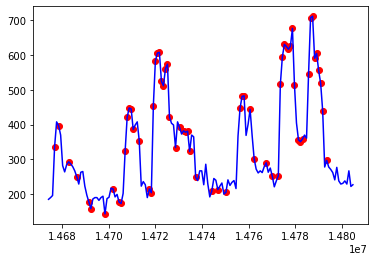

In [46]:
#visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df_concat.loc[df_concat['prediction_dbscan_1'] < 0, ['time_epoch', 'receipts_count']] #anomaly

ax.plot(df_concat['time_epoch'], df_concat['receipts_count'], color='blue')
ax.scatter(a['time_epoch'],a['receipts_count'], color='red')
plt.show()

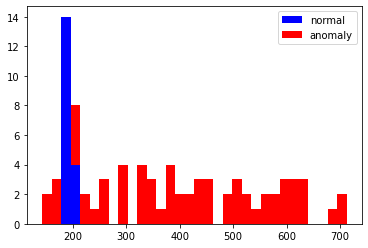

In [47]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df_concat.loc[df_concat['prediction_dbscan_1'] == 0, 'receipts_count']
b = df_concat.loc[df_concat['prediction_dbscan_1'] < 0, 'receipts_count']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## 6.2. Поиск аномалий с помощью агломеративной кластеризации

In [48]:
agglom = AgglomerativeClustering(n_clusters=None, distance_threshold=2)

In [49]:
df_concat['prediction_agglom_1'] = agglom.fit_predict(df_concat['receipts_count'].values.reshape(-1, 1))
df_concat.head()

,brand_id,date,receipts_count,is_game_day,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21,anomaly25,receipts_count_diff,anomaly26,prediction_dbscan_1,prediction_agglom_1
1,178,2016-07-02,185,0.0,5,0,14674176,0,-1.621428,-1.075023,0,0,-49.0,1.0,0,1
2,178,2016-07-03,190,0.0,6,0,14675040,0,-1.850925,-0.945043,0,0,5.0,1.0,0,60
3,178,2016-07-04,196,0.0,0,1,14675904,3,0.574562,-2.027152,0,0,6.0,1.0,0,25
4,178,2016-07-05,336,0.0,1,1,14676768,3,0.445964,-1.493510,0,0,140.0,1.0,-1,92
5,178,2016-07-06,408,0.0,2,1,14677632,3,0.266543,-1.163195,0,0,72.0,1.0,4,53


In [50]:
valcount = df_concat['prediction_agglom_1'].value_counts()
valcount = set(valcount[valcount == 1].index)
df_concat[df_concat.prediction_agglom_1.isin(valcount)]

,brand_id,date,receipts_count,is_game_day,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21,anomaly25,receipts_count_diff,anomaly26,prediction_dbscan_1,prediction_agglom_1
4,178,2016-07-05,336,0.0,1,1,14676768,3,0.445964,-1.493510,0,0,140.0,1.0,-1,92
6,178,2016-07-07,397,0.0,3,1,14678496,3,0.025087,-1.081056,0,0,-11.0,1.0,-1,81
8,178,2016-07-09,282,0.0,5,0,14680224,0,-1.526852,-0.681459,0,0,-88.0,1.0,2,59
11,178,2016-07-12,293,0.0,1,1,14682816,3,0.435904,-1.518559,0,0,8.0,0.0,-1,75
15,178,2016-07-16,250,0.0,5,0,14686272,0,-1.528691,-0.673617,0,0,-17.0,1.0,-1,91
22,178,2016-07-23,158,0.0,5,0,14692320,0,-1.575374,-0.845181,0,0,-20.0,1.0,-1,63
26,178,2016-07-27,182,0.0,2,1,14695776,3,0.163864,-1.528380,0,0,-8.0,0.0,0,58
28,178,2016-07-29,194,0.0,4,1,14697504,3,-0.293636,-1.262441,0,0,4.0,1.0,0,78
29,178,2016-07-30,143,0.0,5,0,14698368,0,-1.564507,-0.786507,0,0,-51.0,1.0,-1,65
37,178,2016-08-07,173,0.0,6,0,14705280,0,-1.753241,-0.478250,0,0,-4.0,1.0,-1,55


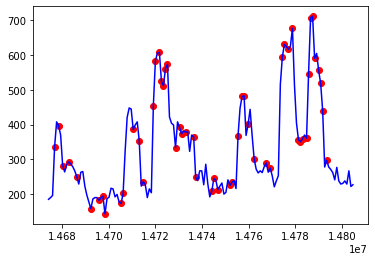

In [51]:
#visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df_concat.loc[df_concat.prediction_agglom_1.isin(valcount), ['time_epoch', 'receipts_count']] #anomaly

ax.plot(df_concat['time_epoch'], df_concat['receipts_count'], color='blue')
ax.scatter(a['time_epoch'],a['receipts_count'], color='red')
plt.show()

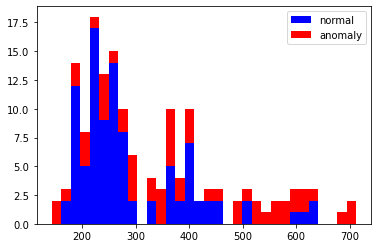

In [52]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df_concat.loc[~df_concat.prediction_agglom_1.isin(valcount), 'receipts_count']
b = df_concat.loc[df_concat.prediction_agglom_1.isin(valcount), 'receipts_count']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## 6.3. Поиск аномалий с помощью кластеризации для всех brand_id

In [53]:
def cluster_anomaly(df):
    """
    Функция для поиска аномалий с помощью DBSCAN и AgglomerativeClustering. 
    """
    for brand in df.brand_id.unique():
        print('-'*80)
        print('Поиск аномалий для brand_id = {}'.format(brand))
        print('-'*80)
        locals()['df_brand_'+str(brand)] = df.loc[df['brand_id'] == brand].copy()
        
        # Создадим новые фичи
        locals()['df_brand_'+str(brand)]['date'] = pd.to_datetime(locals()['df_brand_'+str(brand)]['date'])
        locals()['df_brand_'+str(brand)]['DayOfTheWeek'] = locals()['df_brand_'+str(brand)]['date'].dt.dayofweek
        locals()['df_brand_'+str(brand)]['WeekDay'] = (locals()['df_brand_'+str(brand)]['DayOfTheWeek'] < 5).astype(int)
        locals()['df_brand_'+str(brand)]['time_epoch'] = (locals()[
            'df_brand_'+str(brand)]['date'].astype(np.int64)/100000000000).astype(np.int64)
        
        # Поищем аномалии, с помощью DBSCAN
        dbscan = DBSCAN(min_samples=8, eps=5)
        locals()['df_brand_'+str(brand)]['prediction_dbscan_1'] = dbscan.fit_predict(
            locals()['df_brand_'+str(brand)]['receipts_count'].values.reshape(-1, 1))
        
        locals()['df_brand_'+str(brand)][locals()['df_brand_'+str(brand)].prediction_dbscan_1 < 0]
        
        # Визуализация аномалий по времени
        fig, ax = plt.subplots()
        plt.title(f"Аномалии по времени, найденных с помощью DBSCAN для brand_id = {brand}")
        a = locals()['df_brand_'+str(brand)].loc[locals()['df_brand_'+str(brand)]['prediction_dbscan_1'] < 0, 
                                                 ['time_epoch', 'receipts_count']] #anomaly
        ax.plot(locals()['df_brand_'+str(brand)]['time_epoch'], 
                locals()['df_brand_'+str(brand)]['receipts_count'], 
                color='blue')
        ax.scatter(a['time_epoch'],a['receipts_count'], color='red')
        plt.show()
        
        # Посмотрим на распределение аномальных и действительных значений
        a = locals()['df_brand_'+str(brand)].loc[locals()['df_brand_'+str(brand)]['prediction_dbscan_1'] == 0, 
                                                 'receipts_count']
        b = locals()['df_brand_'+str(brand)].loc[locals()['df_brand_'+str(brand)]['prediction_dbscan_1'] < 0, 
                                                 'receipts_count']
        fig, axs = plt.subplots()
        plt.title(f"Распределение аномальных и действительных значений, найденных с помощью DBSCAN для brand_id = {brand}")
        axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
        plt.legend()
        plt.show()
        print('Количество аномалий, найденных с помощью DBSCAN для brand_id = {}: {}'.
              format(brand, len(locals()['df_brand_'+str(brand)].
                                loc[locals()['df_brand_'+str(brand)]['prediction_dbscan_1'] < 0, 'receipts_count'])))
        print('-'*80)
        
        # Поищем аномалии, с помощью агломеративной кластеризации
        agglom = AgglomerativeClustering(n_clusters=None, distance_threshold=2)
        locals()['df_brand_'+str(brand)]['prediction_agglom_1'] = agglom.fit_predict(
            locals()['df_brand_'+str(brand)]['receipts_count'].values.reshape(-1, 1))
        valcount = locals()['df_brand_'+str(brand)]['prediction_agglom_1'].value_counts()
        valcount = set(valcount[valcount == 1].index)
        locals()['df_brand_'+str(brand)][locals()['df_brand_'+str(brand)].prediction_agglom_1.isin(valcount)]
        
        # Визуализация аномалий по времени
        fig, ax = plt.subplots()
        plt.title(f"Аномалии по времени, найденных с помощью AgglomerativeClustering для brand_id = {brand}")
        a = locals()['df_brand_'+str(brand)].loc[locals()['df_brand_'+str(brand)].prediction_agglom_1.isin(valcount), 
                                                 ['time_epoch', 'receipts_count']] #anomaly
        ax.plot(locals()['df_brand_'+str(brand)]['time_epoch'], 
                locals()['df_brand_'+str(brand)]['receipts_count'], 
                color='blue')
        ax.scatter(a['time_epoch'],a['receipts_count'], color='red')
        plt.show()
        
        # Посмотрим на распределение аномальных и действительных значений
        a = locals()['df_brand_'+str(brand)].loc[~locals()['df_brand_'+str(brand)].prediction_agglom_1.isin(valcount), 
                                                 'receipts_count']
        b = locals()['df_brand_'+str(brand)].loc[locals()['df_brand_'+str(brand)].prediction_agglom_1.isin(valcount), 
                                                 'receipts_count']
        fig, axs = plt.subplots()
        plt.title(f'Распределение аномальных и действительных значений,' 
                  f'найденных с помощью AgglomerativeClustering для brand_id = {brand}')
        axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
        plt.legend()
        plt.show()
        print('Количество аномалий, найденных с помощью AgglomerativeClustering для brand_id = {}: {}'.
              format(brand, len(locals()['df_brand_'+str(brand)].
                                loc[locals()['df_brand_'+str(brand)].prediction_agglom_1.isin(valcount), 'receipts_count'])))
    return "Done"        

--------------------------------------------------------------------------------
Поиск аномалий для brand_id = 5152
--------------------------------------------------------------------------------


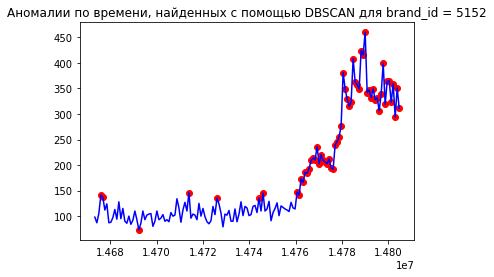

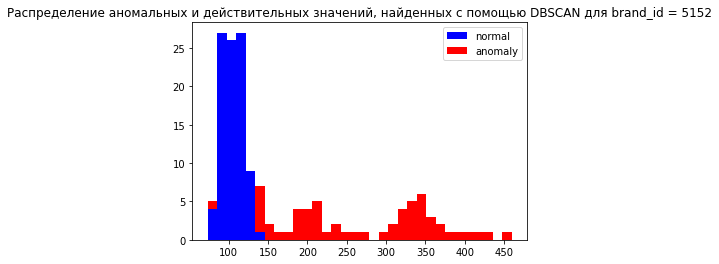

Количество аномалий, найденных с помощью DBSCAN для brand_id = 5152: 59
--------------------------------------------------------------------------------


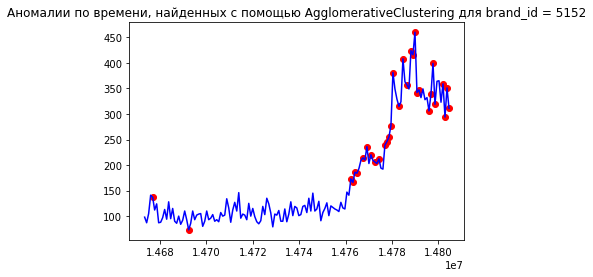

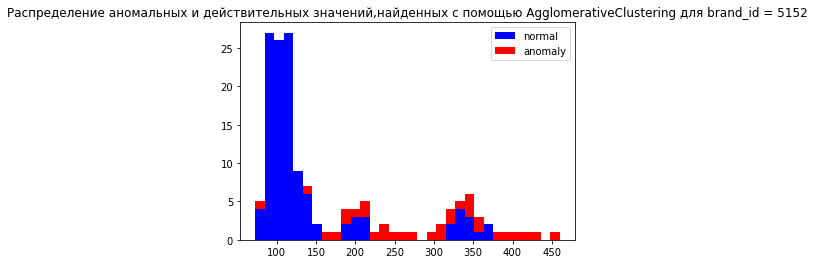

Количество аномалий, найденных с помощью AgglomerativeClustering для brand_id = 5152: 32
--------------------------------------------------------------------------------
Поиск аномалий для brand_id = 178
--------------------------------------------------------------------------------


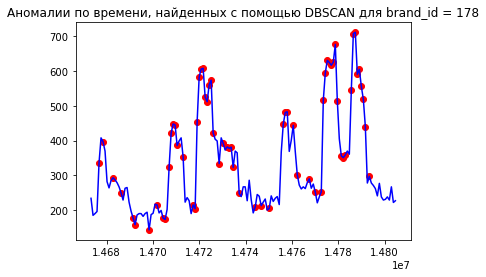

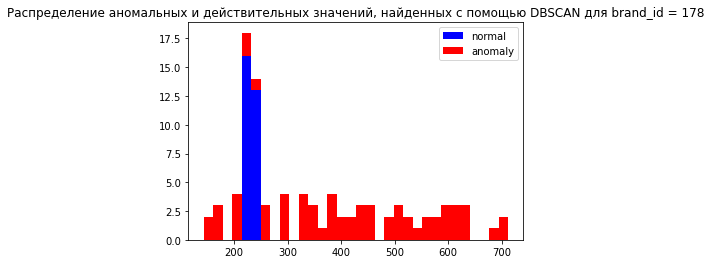

Количество аномалий, найденных с помощью DBSCAN для brand_id = 178: 65
--------------------------------------------------------------------------------


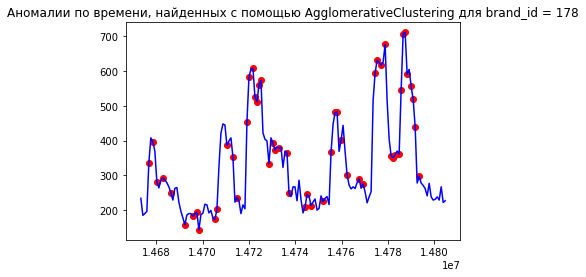

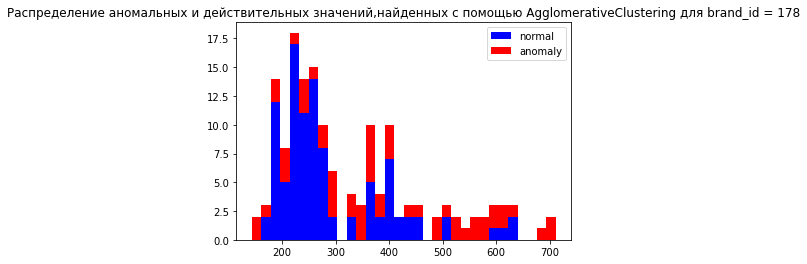

Количество аномалий, найденных с помощью AgglomerativeClustering для brand_id = 178: 54
--------------------------------------------------------------------------------
Поиск аномалий для brand_id = 29
--------------------------------------------------------------------------------


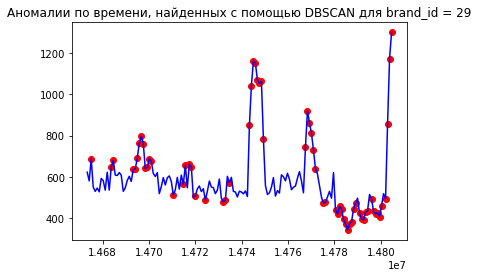

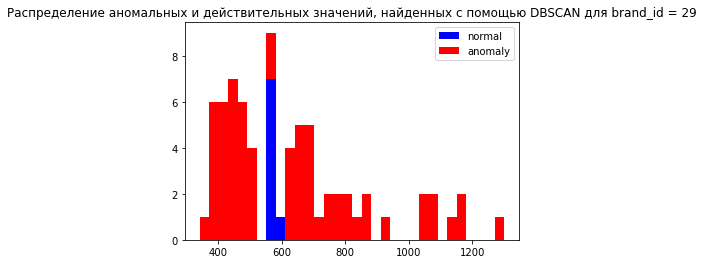

Количество аномалий, найденных с помощью DBSCAN для brand_id = 29: 65
--------------------------------------------------------------------------------


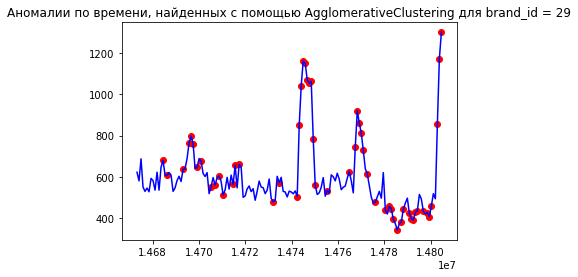

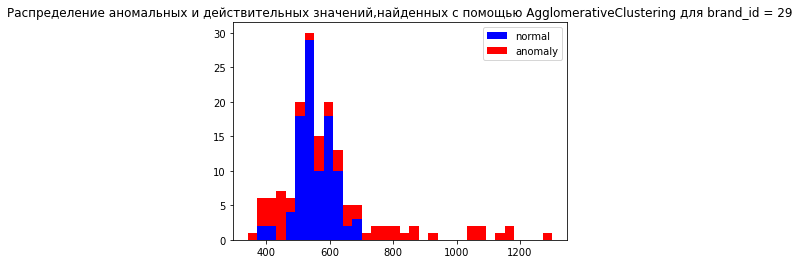

Количество аномалий, найденных с помощью AgglomerativeClustering для brand_id = 29: 55


'Done'

In [54]:
cluster_anomaly(df)